In [2]:
import torch
from torch import nn
# aliter: import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import math
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as TF
import random

import numpy as np
import cv2
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
from collections import namedtuple
from torchvision import models

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transfer import transfer_model
from dataset import SRdatasets
from model import FSRCNN
from utils import PSNR, predict, display_random, display_particular
from vgg import Vgg16, PerceptualLoss



# Initialize VGG-16 feature extractor (requires_grad=False for fixed weights)
vgg_model = Vgg16(requires_grad=False).to(device)

# Initialize Perceptual Loss
perceptual_loss_fn = PerceptualLoss(vgg_model).to(device)

# instantiate dataset object
dataset = SRdatasets(dataset_path = 'C:/Users/athar/MLprojects/dataloader_task/Datasets')

print("dataset class, vgg model, and perceptual loss function initialised successfully")

C:\Users\athar\anaconda3\envs\gpu_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\athar\anaconda3\envs\gpu_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


dataset class, vgg model, and perceptual loss function initialised successfully


checkpoint loaded successfully


transfer previous model? 1/0:  1


model transfered successfully


transfer the previous train, val, and test sets? (1/0):  0
start traning?(1) OR skip to inference?(0):  0


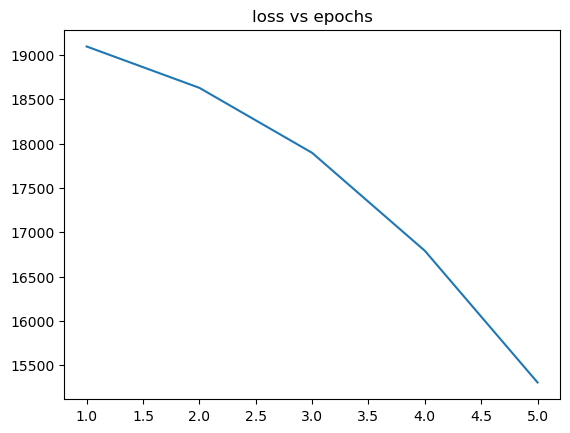

epoch_loss_list:  [19093.772506713867, 18627.521942138672, 17894.965103149414, 16790.90965270996, 15306.213806152344]


ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

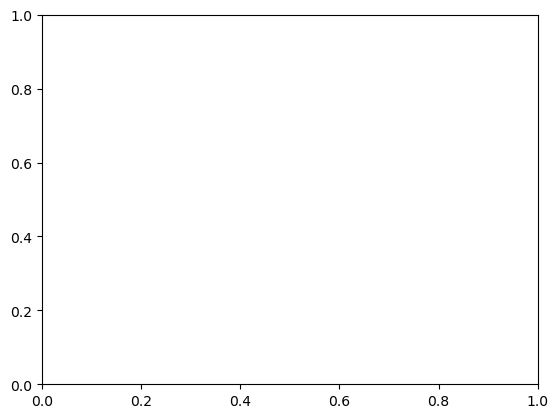

In [4]:

train_size = 512*2 # 512*2 = 1024, *2 becuase of deterministic transform (horizontal flip)
# val_size = 17*2
# test_size = 17*2
test_size = 17*4

num_epochs = 5
learning_rate = 1e-3
batch_size = 16


model = FSRCNN().to(device)
pixel_loss = nn.MSELoss()
optimizer = torch.optim.SGD(
    [
        {'params': model.first_part.parameters()},
        {'params': model.mid_part.parameters()},
        {'params': model.last_part.parameters(), 'lr': learning_rate * 0.1}
    ],
    lr = learning_rate
) # "low learning rate for last layer gives promising results" ~authors of SRCNN paper

batch_loss_agg = 0 # batch loss aggregator (aggregates the loss accross given batch)
batch_acc_agg = 0
epoch_loss = 0

epoch_loss_list = []
epoch_acc_list = []


# variables for validation accuracy
batch_val_agg = 0
batch_val_list = []
epoch_val_list = []

prev_epochs = 0

train_set, test_set, prev_epochs = transfer_model(dataset, model, optimizer, epoch_loss_list, epoch_acc_list, train_size, test_size, prev_epochs)

# initialising train and test loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
# val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

num_of_batches = len(train_loader)

# training
start_training = int(input("start traning?(1) OR skip to inference?(0): "))

if start_training:
    print("starting training")
    gradient_accumulation_steps = 2 # effectivec batch size = 32
    for epoch in range(num_epochs):
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
    
            outputs = model(inputs)
            outputs = outputs.to(device)
            perceptual_loss = perceptual_loss_fn(outputs, targets)
            loss = pixel_loss(outputs, targets) + 0.04* perceptual_loss
    
            loss.backward() # computes and accumulates gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
    
            if( (i+1) % gradient_accumulation_steps == 0 ):
                optimizer.step() # updates parameters after 4 batches (64 images) are analysed
                optimizer.zero_grad() # resets gradients to 0
                
            
            batch_loss_agg = batch_loss_agg + loss.item()/num_of_batches
    
            step_train_accuracy = PSNR().batch(outputs, targets)
            psnr_input = PSNR().batch(inputs, targets)
       
            batch_acc_agg = batch_acc_agg + step_train_accuracy/num_of_batches
    
            
            if (i + 1) % 4 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, PSNR: {step_train_accuracy:.4f}, diff(pred - input): {(step_train_accuracy - psnr_input):.4f} ')
    
            # for freeing up gpu space
            # del inputs, targets, outputs, loss
            # torch.cuda.empty_cache()
            
        epoch_acc_list.append(batch_acc_agg)
        epoch_loss_list.append(batch_loss_agg)
        
        batch_loss_agg = 0
        batch_acc_agg = 0

# plotting quality metrics
plt.plot(range(1, prev_epochs + start_training*num_epochs+1), epoch_loss_list)
plt.title('loss vs epochs')
plt.show()
print('epoch_loss_list: ', epoch_loss_list)
plt.plot(range(1, prev_epochs + start_training*num_epochs+1), epoch_acc_list)
plt.title('PSNR vs epochs')
print('Training finished')
plt.show()


# displaying some randomly picked examples
display_random(test_loader, model, batch_size)

# for observing a particular sample (particular image)
see_part = int(input('want to see particular image?(1/0): '))
if see_part:
    i = int(input("Enter the number of example to display: "))
    display_particular(i, model)

# saving model
PATH = "fsrcnn_phase1.pt"
torch.save({
            'epoch_loss_list': epoch_loss_list,
            'epoch_acc_list': epoch_acc_list,
            'epoch': prev_epochs + num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'train_set': train_set,
            # 'test_set': test_set,
            }, PATH)

print(f"model saved as '{PATH}'")
# stores at: C:\Users\athar\AppData\Roaming\Python\Python312\site-packages
  

In [6]:

display_random(test_loader, model, batch_size)



Some examples: 


ValueError: axes don't match array

In [13]:
# saving model
PATH = "fsrcnn_phase1.pt"
torch.save({
            'epoch_loss_list': epoch_loss_list,
            'epoch_acc_list': epoch_acc_list,
            'epoch': prev_epochs + num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # 'train_set': train_set,
            # 'test_set': test_set,
            }, PATH)

print(f"model saved as '{PATH}'")
# stores at: C:\Users\athar\AppData\Roaming\Python\Python312\site-packages

model saved as 'fsrcnn_phase1.pt'


In [6]:
print(epoch_loss_list)

[]
